In [30]:
import os
os.environ["OMP_NUM_THREADS"] = "3"

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans 
from sklearn.preprocessing import LabelEncoder 
from sklearn.decomposition import PCA 
from sklearn.utils import shuffle 
from sklearn.metrics import silhouette_score 

file_path = r"C:\Users\nessy.wangari_suncul\Documents\ME @ 2025\Customer Persona\Customer Persona Data added columns.csv"

# Read only headers with correct encoding
all_columns = pd.read_csv(file_path, encoding='ISO-8859-1', nrows=0).columns.tolist()

# Exclude 'gender' and 'region'
use_columns = [col for col in all_columns if col not in ['gender ', 'region', 'NPS Date']]

# Read full data using only selected columns
df = pd.read_csv(file_path, usecols=use_columns, encoding='ISO-8859-1')

print(df.head())

   customerId         age                 Lead Source  \
0        21975  3135 years                             
1        53039  3640 years                             
2        40815          NaN                             
3        78918  2630 years              Social Media   
4       130761  3135 years  Referral / Word of Mouth   

             main source of income water source  \
0  farming/ agriculture activities          NaN   
1        commerce/trade activities          NaN   
2                              NaN          NaN   
3            provision of services         Well   
4        commerce/trade activities         Well   

                                   Motivation to buy Primary decision maker  \
0  Increase of agriculture production for self co...                Husband   
1  Increase of agriculture production for self co...                   Wife   
2                                                NaN                    NaN   
3        Increase of agriculture p

In [41]:
# Missing values
missing_percent = df.isnull().mean().round(4) * 100

missing_summary = pd.DataFrame({
    'Column': missing_percent.index,
    'Missing Percentage': missing_percent.values
})

missing_summary = missing_summary.sort_values(by='Missing Percentage', ascending=False).reset_index(drop=True)

print(missing_summary)

                       Column  Missing Percentage
0                social_media               91.67
1      Primary decision maker               16.69
2                water source               11.65
3                       age                 11.41
4             Crops/livestock               11.16
5                Farm acreage               10.82
6       main source of income               10.52
7           Motivation to buy               10.38
8                 customerId                 0.00
9                 Lead Source                0.00
10  Practical/emotional goals                0.00
11                   accounts                0.00
12          household_members                0.00
13               income_level                0.00
14                  Discounts                0.00


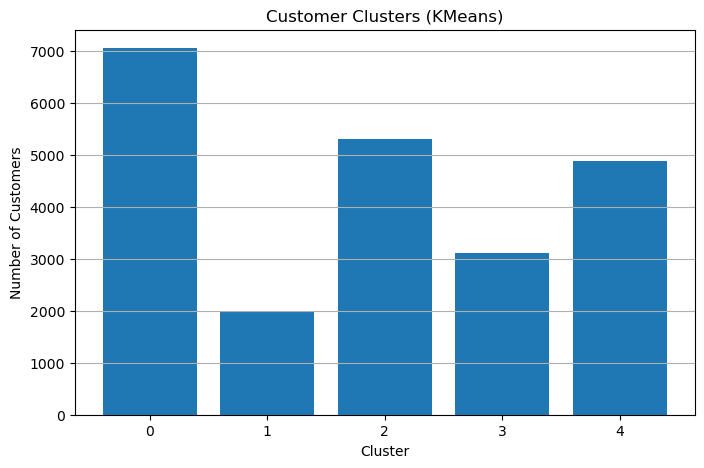

Silhouette Score: 0.37863466901335957
cluster
0    7055
2    5304
4    4877
3    3113
1    1967
Name: count, dtype: int64


PermissionError: [Errno 13] Permission denied: 'clustered_customers_household.csv'

In [42]:
# K-Means Classification

df.columns = [col.strip().lower().replace("  ", " ").replace(" ", "_") for col in df.columns]

df = df.loc[:, ~df.columns.str.contains("cluster")]

def normalize(text):
    if pd.isna(text):
        return "missing"
    return str(text).strip().lower()

object_columns = df.select_dtypes(include=["object"]).columns
for col in object_columns:
    df[col] = df[col].apply(normalize)

label_encoder = LabelEncoder()
for col in object_columns:
    df[col] = label_encoder.fit_transform(df[col].astype(str))

df = df.apply(pd.to_numeric, errors="coerce")

features = df.columns.tolist()
feature_weights = {col: 1 for col in features}
for feature in feature_weights:
    df[feature] *= feature_weights[feature]

numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features)
])

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("pca", PCA(n_components=2)),
    ("clusterer", KMeans(n_clusters=5, random_state=42, init="k-means++"))
])

pipeline.fit(df[features])
df["cluster"] = pipeline.named_steps["clusterer"].labels_

cluster_counts = df["cluster"].value_counts().sort_index()
plt.figure(figsize=(8, 5))
plt.bar(cluster_counts.index.astype(str), cluster_counts.values)
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.title("Customer Clusters (KMeans)")
plt.grid(axis='y')
plt.show()

X_transformed = pipeline.named_steps["pca"].transform(
    pipeline.named_steps["preprocessor"].transform(df[features])
)
silhouette_avg = silhouette_score(X_transformed, df["cluster"])
print(f"Silhouette Score: {silhouette_avg}")
print(df["cluster"].value_counts())

output_file = "clustered_customers_household.csv"
df.to_csv(output_file, index=False)
print(f"\nClustered data saved to '{output_file}'")

print("\n=== Sample from each cluster ===\n")
for c in sorted(df["cluster"].unique()):
    print(f"\nCluster {c} Sample:")
    cols_to_show = [col for col in [
        "customerid", "age", "farm_acreage", "crops/livestock",
        "main_source_of_income", "lead_source", "sentiment",
        "social_media", "accounts", "household_members",
        "income_level", "discounts"
    ] if col in df.columns]
    print(df[df["cluster"] == c][cols_to_show].head(3))


=== Ranked Feature Importance (Centroid Std Deviation) ===
                      Feature  Centroid_StdDev  Rank
0       main_source_of_income         3.101484     1
1                 lead_source         2.646645     2
2                         age         2.226414     3
3           household_members         1.291488     4
4             crops/livestock         0.928585     5
5                water_source         0.921929     6
6                income_level         0.601859     7
7           motivation_to_buy         0.533309     8
8                   discounts         0.493594     9
9      primary_decision_maker         0.357954    10
10               farm_acreage         0.172053    11
11  practical/emotional_goals         0.102674    12
12               social_media         0.093866    13
13                   accounts         0.045386    14


C:\Users\nessy.wangari_suncul\AppData\Local\Temp\ipykernel_8552\918473858.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_sorted, x="Centroid_StdDev", y="Feature", palette="viridis")


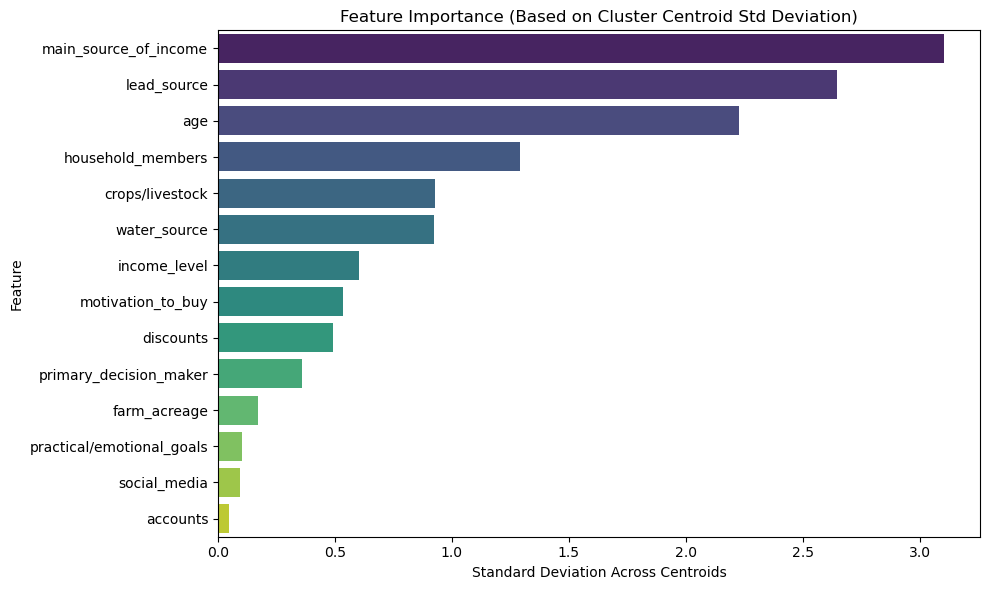

In [33]:
# Cluster Centroid Analysis

df_cluster = df.copy()
df_cluster_fixed = df_cluster.drop(columns=["customerid", "cluster"], errors="ignore")

imputer = SimpleImputer(strategy="median")
df_cluster_imputed = pd.DataFrame(imputer.fit_transform(df_cluster_fixed), columns=df_cluster_fixed.columns)

kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_cluster["cluster"] = kmeans.fit_predict(df_cluster_imputed)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=df_cluster_imputed.columns)
feature_importance = centroids.std().sort_values(ascending=False).reset_index()
feature_importance.columns = ["Feature", "Centroid_StdDev"]
feature_importance["Rank"] = feature_importance["Centroid_StdDev"].rank(ascending=False).astype(int)

print("=== Ranked Feature Importance (Centroid Std Deviation) ===")
print(feature_importance.sort_values("Rank").reset_index(drop=True))

feature_importance_sorted = feature_importance.sort_values("Centroid_StdDev", ascending=False)

# Plot feature importance as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_sorted, x="Centroid_StdDev", y="Feature", palette="viridis")
plt.title("Feature Importance (Based on Cluster Centroid Std Deviation)")
plt.xlabel("Standard Deviation Across Centroids")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



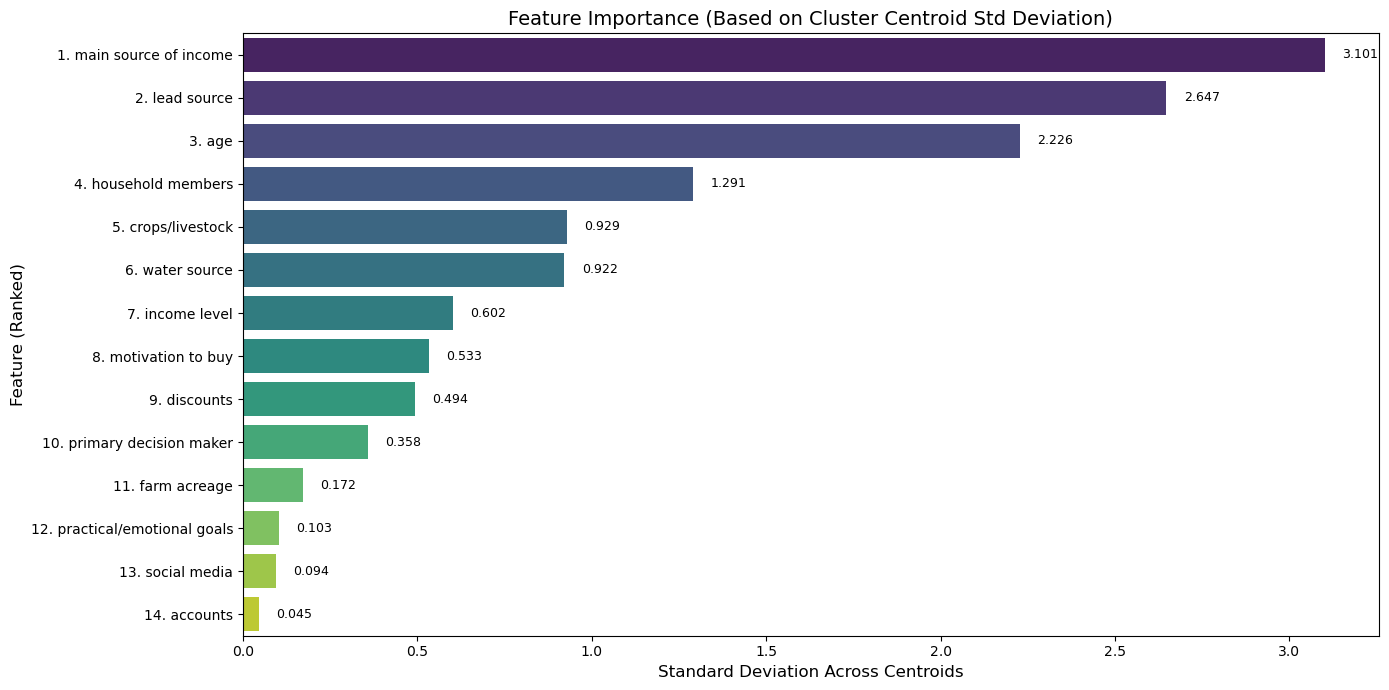

In [43]:
 warnings.simplefilter(action='ignore', category=FutureWarning)  # Optional

feature_importance = pd.DataFrame({
    "Feature": ["main source of income", "lead source", "age", "household members", "crops/livestock",
                "water source", "income level", "motivation to buy", "discounts", "primary decision maker",
                "farm acreage", "practical/emotional goals", "social media", "accounts"],
    "Centroid_StdDev": [3.101484, 2.646645, 2.226414, 1.291488, 0.928585, 0.921929, 0.601859,
                        0.533309, 0.493594, 0.357954, 0.172053, 0.102674, 0.093866, 0.045386]
})

feature_importance["Rank"] = feature_importance["Centroid_StdDev"].rank(ascending=False).astype(int)
feature_importance = feature_importance.sort_values("Centroid_StdDev", ascending=False)

feature_importance["Feature_Label"] = feature_importance["Rank"].map(str) + ". " + feature_importance["Feature"].astype(str)

plt.figure(figsize=(14, 7))
barplot = sns.barplot(data=feature_importance, x="Centroid_StdDev", y="Feature_Label", palette="viridis")

for i, (value, label) in enumerate(zip(feature_importance["Centroid_StdDev"], feature_importance["Feature_Label"])):
    plt.text(value + 0.05, i, f"{value:.3f}", va='center', fontsize=9)

plt.title("Feature Importance (Based on Cluster Centroid Std Deviation)", fontsize=14)
plt.xlabel("Standard Deviation Across Centroids", fontsize=12)
plt.ylabel("Feature (Ranked)", fontsize=12)
plt.tight_layout()

plt.show()